# Aim

The aim of the anaylsis is to investigate the stability of cNE patterns in spantaneous activities and stimulus-driven activities. 

In [173]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
%matplotlib inline

from scipy import signal, stats
from scipy.stats import zscore

from helper import chi_square
from plot_box import plot_significance_star

# get colors for box plots
colors = sns.color_palette("Paired")
A1_color = (colors[1], colors[0], colors[3], colors[2])
MGB_color = (colors[5], colors[4], colors[7], colors[6])
colors_split = [colors[i] for i in [3, 2, 7, 6, 9, 8]]


## Load Data 

In [2]:
datafolder = r'/Users/hucongcong/Documents/UCSF/data/data-summary'
df = pd.read_json(os.path.join(datafolder, 'split_cNE.json'))

## Inspect Data

In [3]:
"""
member: True if the two neurons in the pair appeared the same cNE, otherwise, false
region: MGB or A1
stim: dmr -- 2 patterns all under dmr
      spon -- 2 patterns all uner spon
      cross -- 1 pattern from spon, 1 pattern from dmr; if dmr_first, the first pattern is from dmr, other wise from spon
idx: pattern idx under the stimulus condition
corr: correlattion coeeficient of the 2 patterns
corr_thresh: significant correlation threshold at p=0.01
"""
df.head()

,exp,probe,region,stim,dmr_first,idx1,idx2,pattern1,pattern2,corr,corr_thresh,corr_sig,n_neuron
0,210715201351,H31x64,MGB,dmr,True,1,0,"[0.0897109132, 0.4638610554, -0.0627908716, 0....","[0.3677574738, 0.329001074, 0.2689638788, 0.35...",0.614550,0.801884,False,9
1,210715201351,H31x64,MGB,spon,True,0,1,"[0.3835528634, 0.18605720850000002, 0.23607617...","[-0.02636698, -0.1892202342, 0.5495066334, 0.3...",0.206984,0.803760,False,9
2,210715201351,H31x64,MGB,cross,True,0,0,"[0.3677574738, 0.329001074, 0.2689638788, 0.35...","[0.3835528634, 0.18605720850000002, 0.23607617...",0.279742,0.807811,False,9
3,210223165503,H31x64,MGB,dmr,False,0,2,"[0.3796602112, 0.4855612644, 0.439590939, 0.32...","[0.3282171698, 0.25629792230000004, 0.53166170...",0.902069,0.642110,True,15
4,210223165503,H31x64,MGB,dmr,False,2,0,"[-0.26819974820000003, -0.291174998, 0.1085772...","[-0.31949930330000004, -0.2658897806, 0.056801...",0.943359,0.642110,True,15


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 0 to 509
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   exp          510 non-null    int64  
 1   probe        510 non-null    object 
 2   region       510 non-null    object 
 3   stim         510 non-null    object 
 4   dmr_first    510 non-null    bool   
 5   idx1         510 non-null    int64  
 6   idx2         510 non-null    int64  
 7   pattern1     510 non-null    object 
 8   pattern2     510 non-null    object 
 9   corr         510 non-null    float64
 10  corr_thresh  510 non-null    float64
 11  corr_sig     510 non-null    bool   
 12  n_neuron     510 non-null    int64  
dtypes: bool(2), float64(2), int64(4), object(5)
memory usage: 48.8+ KB


## Add Features

In [5]:
# get pattern correlation significance
df['corr_sig'] = df['corr'] > df['corr_thresh']
# get number of neurons in the recording
df['n_neuron'] = df['pattern1'].apply(len)
df.to_json(os.path.join(datafolder, 'split_cNE.json'))

In [6]:
df.head()

,exp,probe,region,stim,dmr_first,idx1,idx2,pattern1,pattern2,corr,corr_thresh,corr_sig,n_neuron
0,210715201351,H31x64,MGB,dmr,True,1,0,"[0.0897109132, 0.4638610554, -0.0627908716, 0....","[0.3677574738, 0.329001074, 0.2689638788, 0.35...",0.614550,0.801884,False,9
1,210715201351,H31x64,MGB,spon,True,0,1,"[0.3835528634, 0.18605720850000002, 0.23607617...","[-0.02636698, -0.1892202342, 0.5495066334, 0.3...",0.206984,0.803760,False,9
2,210715201351,H31x64,MGB,cross,True,0,0,"[0.3677574738, 0.329001074, 0.2689638788, 0.35...","[0.3835528634, 0.18605720850000002, 0.23607617...",0.279742,0.807811,False,9
3,210223165503,H31x64,MGB,dmr,False,0,2,"[0.3796602112, 0.4855612644, 0.439590939, 0.32...","[0.3282171698, 0.25629792230000004, 0.53166170...",0.902069,0.642110,True,15
4,210223165503,H31x64,MGB,dmr,False,2,0,"[-0.26819974820000003, -0.291174998, 0.1085772...","[-0.31949930330000004, -0.2658897806, 0.056801...",0.943359,0.642110,True,15


## Summary Plots

#### Distribution of significant correlation values

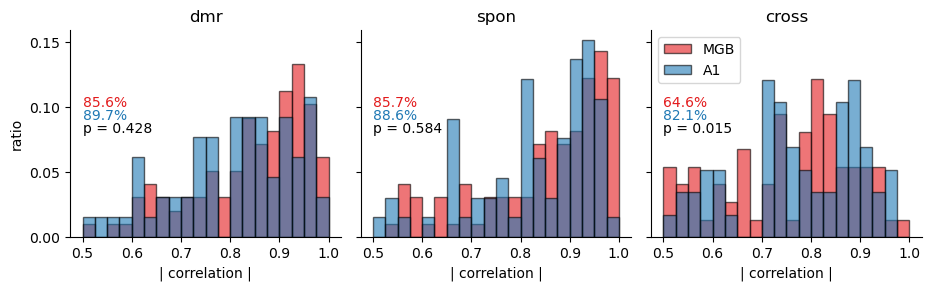

In [7]:
bins=np.linspace(0.5, 1, 21)
g = sns.FacetGrid(df, col="stim", hue="region", palette=[MGB_color[0], A1_color[0]])
g.map(plt.hist, 'corr', bins=bins, ec='k', alpha=0.6, density=True)
axes = g.axes[0]
for ax in axes:
    ax.set_xlabel('| correlation |')
    title = ax.get_title()
    stim = title[7:]
    ax.set_title(stim)
    n_ne_sig = np.empty(2)
    n_ne = np.empty(2)
    for i, region in enumerate(('MGB', 'A1')):
        corr_sig = df[(df.stim == stim) & (df.region == region)]['corr_sig']
        ratio = corr_sig.mean()
        n_ne_sig[i] = corr_sig.sum()
        n_ne[i] = len(corr_sig)
        ax.text(0.5, 4 - 0.4 * i, '{:.1f}%'.format(ratio*100), color=eval('{}_color[0]'.format(region)))
        
    _, p = chi_square(n_ne_sig, n_ne)
    ax.text(0.5, 3.2, 'p = {:.3f}'.format(p), color='k')

axes[-1].legend()
axes[0].set_yticks(range(0, 7, 2))
axes[0].set_yticklabels(map(lambda x: '{:.2f}'.format(x), np.arange(0, 0.2, 0.05)))
axes[0].set_ylabel('ratio')
plt.show()

In [8]:
for region in ('MGB', 'A1'):
    
    print(region)
    dmr = df[(df.stim == 'dmr') & (df.region == region)]['corr_sig'].apply((sum, len))
    spon = df[(df.stim == 'spon') & (df.region == region)]['corr_sig'].apply((sum, len))
    cross = df[(df.stim == 'cross') & (df.region == region)]['corr_sig'].apply((sum, len))
    
    print('dmr vs spon: p = {:.4f}'.format(chi_square([dmr[0], spon[0]], [dmr[1], spon[1]])[1]))
    print('dmr vs spon: p = {:.4f}'.format(chi_square([dmr[0], cross[0]], [dmr[1], cross[1]])[1]))
    print('dmr vs spon: p = {:.4f}'.format(chi_square([spon[0], cross[0]], [spon[1], cross[1]])[1]))
    print('')

MGB
dmr vs spon: p = 0.9774
dmr vs spon: p = 0.0006
dmr vs spon: p = 0.0005

A1
dmr vs spon: p = 0.8305
dmr vs spon: p = 0.2033
dmr vs spon: p = 0.2828



#### comparison of correlation values under different stimulus conditions (box plot)

In [9]:
df['region_stim'] = df[['region', 'stim']].apply(tuple, axis=1)
df['region_stim'] = df['region_stim'].apply(lambda x: '_'.join([str(y) for y in x]))
my_order = df.groupby(by=['region', 'stim'])['corr'].mean().iloc[::-1].index
my_order = ['_'.join([str(y) for y in x]) for x in my_order]
order_idx = [1, 4, 0, 3, 2, 5]
my_order = [my_order[i] for i in order_idx]
print(my_order)

['MGB_dmr', 'A1_dmr', 'MGB_spon', 'A1_spon', 'MGB_cross', 'A1_cross']


significance test: MGB vs A1
MannwhitneyuResult(statistic=4045.0, pvalue=0.11126584863473588)
MannwhitneyuResult(statistic=4114.0, pvalue=0.181696336186018)
MannwhitneyuResult(statistic=2739.0, pvalue=0.1080197032818191)
significance test: dmr vs spon
MannwhitneyuResult(statistic=5096.0, pvalue=0.40567845109014833)
MannwhitneyuResult(statistic=2172.0, pvalue=0.3768658794641755)
significance test: cross vs spon/stim (MGB)
MannwhitneyuResult(statistic=2605.0, pvalue=3.4191079172904914e-09)
MannwhitneyuResult(statistic=2679.0, pvalue=1.5597108187671183e-08)
significance test: cross vs spon/stim (A1)
MannwhitneyuResult(statistic=1597.0, pvalue=0.0012878859109043683)
MannwhitneyuResult(statistic=1761.0, pvalue=0.023026116461027438)


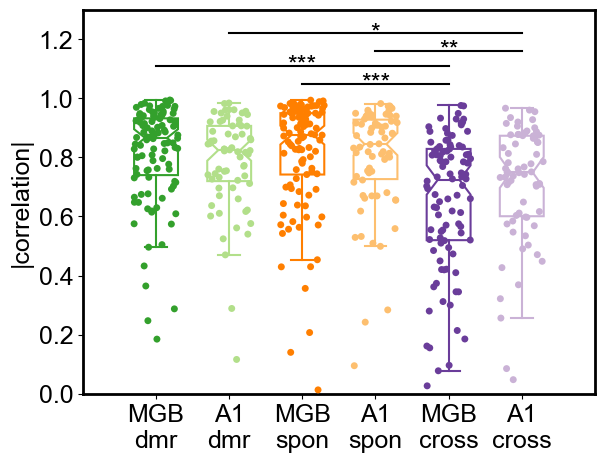

In [31]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 

sns.stripplot(x='region_stim', y='corr', data=df, order=my_order, 
              hue='region_stim', palette=colors_split, hue_order=my_order, 
              jitter=0.3, legend=False)
bplot = sns.boxplot(x='region_stim', y='corr', data=df, order=my_order, 
                    width=0.6, notch=True, flierprops={'marker': ''})

for i,box_col in enumerate(colors_split):
    
    mybox = bplot.patches[i]
    
    mybox.set_edgecolor(box_col)
    mybox.set_facecolor('w')

    for j in range(i*6,i*6+6):
        line = bplot.lines[j]
        line.set_color(box_col)
        line.set_mfc(box_col)
        line.set_mec(box_col)

ax.set_xticklabels(['\n'.join(x.split('_')) for x in my_order])
ax.set_xlim([-1, 6])
ax.set_ylabel('|correlation|');

# significance test between 2 regions
print('significance test: MGB vs A1')
for i in range(3):
    res = stats.mannwhitneyu(x=df[df['region_stim'] == my_order[i*2]]['corr'], 
                            y=df[df['region_stim'] == my_order[i*2+1]]['corr'])
    print(res)
    p = res.pvalue
    plot_significance_star(ax, p, [i*2, i*2+1], 1.05, 1.07)

# significance test between dmr and spon
print('significance test: dmr vs spon')
for i in range(2):
    res = stats.mannwhitneyu(x=df[df['region_stim'] == my_order[i]]['corr'], 
                            y=df[df['region_stim'] == my_order[i+2]]['corr'])
    print(res)
    p = res.pvalue
    plot_significance_star(ax, p, [i, i+2], 1.05, 1.07)

# significance test between cross condition and within condition in MGB
print('significance test: cross vs spon/stim (MGB)')
for i in range(2):
    res = stats.mannwhitneyu(x=df[df['region_stim'] == my_order[4]]['corr'], 
                            y=df[df['region_stim'] == my_order[2 - i*2]]['corr'])
    print(res)
    p = res.pvalue
    plot_significance_star(ax, p, [2 - i*2, 4], 1.05+i*0.06, 1.05+i*0.06)

# significance test between dmr and cross
print('significance test: cross vs spon/stim (A1)')
for i in range(2):
    res = stats.mannwhitneyu(x=df[df['region_stim'] == my_order[5]]['corr'], 
                            y=df[df['region_stim'] == my_order[3 - i*2]]['corr'])
    print(res)
    p = res.pvalue
    plot_significance_star(ax, p, [3 - i*2, 5], 1.16+i*0.06, 1.16+i*0.06)
    
ax.set_ylim([0, 1.3])
ax.set_xlabel('')
plt.show()

#### Scatter plot of within and cross condition values

In [66]:
df_cross = pd.concat([
df[(df.stim == 'cross') & (df.dmr_first)].merge(
    df[(df.stim == 'dmr') & (df.dmr_first)], 
    left_on=['exp', 'region', 'idx1'], right_on=['exp', 'region', 'idx2'], 
    suffixes=(None, '_dmr'), how='left').merge(
    df[(df.stim == 'spon') & (df.dmr_first)], 
    left_on=['exp', 'region','idx2'], right_on=['exp', 'region', 'idx1'], 
    suffixes=(None, '_spon'), how='left'),
df[(df.stim == 'cross') & (~df.dmr_first)].merge(
    df[(df.stim == 'dmr') & (~df.dmr_first)], 
    left_on=['exp', 'region','idx2'], right_on=['exp', 'region', 'idx1'], 
    suffixes=(None, '_dmr'), how='left').merge(
    df[(df.stim == 'spon') & (~df.dmr_first)], 
    left_on=['exp', 'region','idx1'], right_on=['exp', 'region', 'idx2'], 
    suffixes=(None, '_spon'), how='left')
])

In [68]:
df_cross.head()

,exp,probe,region,stim,dmr_first,idx1,idx2,pattern1,pattern2,corr,...,dmr_first_spon,idx1_spon,idx2_spon,pattern1_spon,pattern2_spon,corr_spon,corr_thresh_spon,corr_sig_spon,n_neuron_spon,region_stim_spon
0,210715201351,H31x64,MGB,cross,True,0,0,"[0.3677574738, 0.329001074, 0.2689638788, 0.35...","[0.3835528634, 0.18605720850000002, 0.23607617...",0.279742,...,True,0,1,"[0.3835528634, 0.18605720850000002, 0.23607617...","[-0.02636698, -0.1892202342, 0.5495066334, 0.3...",0.206984,0.803760,False,9,MGB_spon
1,210805202306,H31x64,MGB,cross,True,1,2,"[0.06736965140000001, -0.0803762419, 0.0719377...","[0.0628710708, 0.020540148, -0.0417183849, -0....",0.916747,...,True,2,1,"[0.0628710708, 0.020540148, -0.0417183849, -0....","[0.0594386203, 0.0091305897, -0.007850299, -0....",0.973710,0.588659,True,19,MGB_spon
2,210805202306,H31x64,MGB,cross,True,2,0,"[-0.0029846158, 0.0024098585, 0.0659382104, -0...","[-0.0275732092, -0.0090929737, 0.3390761877000...",0.881565,...,True,0,2,"[-0.0275732092, -0.0090929737, 0.3390761877000...","[0.0055845611000000005, -0.0190111845, 0.26453...",0.904421,0.588659,True,19,MGB_spon
3,210805202306,H31x64,MGB,cross,True,3,1,"[0.44269402300000005, 0.4928080179, 0.33957411...","[0.5308515336, 0.5236545201, 0.0650167047, 0.3...",0.829158,...,True,1,3,"[0.5308515336, 0.5236545201, 0.0650167047, 0.3...","[0.48920082800000003, 0.5236358364, 0.10200321...",0.940218,0.588659,True,19,MGB_spon
4,210401175257,H31x64,MGB,cross,True,1,1,"[0.3757793266, 0.398314577, -0.0333976806, 0.5...","[0.0680823475, 0.4251374791, -0.0087239941, 0....",0.768994,...,True,1,1,"[0.0680823475, 0.4251374791, -0.0087239941, 0....","[0.09353615180000001, 0.4579567041, 0.04056643...",0.825927,0.590218,True,18,MGB_spon


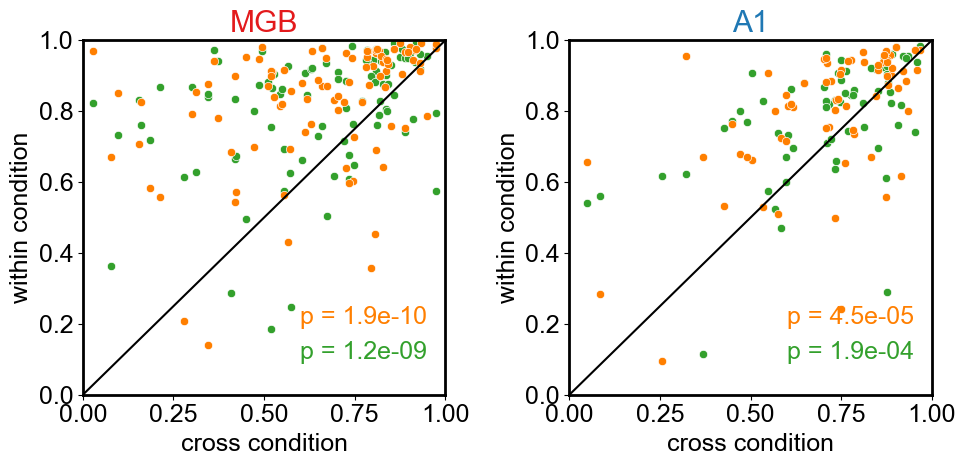

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
regions = ('MGB', 'A1')
for i in range(2):
    sns.scatterplot(data=df_cross[df_cross.region==regions[i]], 
                    x='corr', y='corr_dmr', 
                    ax=axes[i], color=colors_split[0])
    sns.scatterplot(data=df_cross[df_cross.region==regions[i]], 
                    x='corr', y='corr_spon', 
                    ax=axes[i], color=colors_split[2])
    axes[i].plot([0, 1], [0, 1], color='k')
    
    axes[i].set_xlabel('cross condition')
    axes[i].set_ylabel('within condition')
    axes[i].set_xlim([0, 1])
    axes[i].set_ylim([0, 1])
    axes[i].set_title(regions[i], color=eval('{}_color[0]'.format(regions[i])))
    
    _, p = stats.wilcoxon(x=df_cross[df_cross.region==regions[i]]['corr'], 
                          y=df_cross[df_cross.region==regions[i]]['corr_dmr'])
    axes[i].text(0.6, 0.1, 'p = {:.1e}'.format(p), color=colors_split[0])
    _, p = stats.wilcoxon(x=df_cross[df_cross.region==regions[i]]['corr'], 
                          y=df_cross[df_cross.region==regions[i]]['corr_spon'])
    axes[i].text(0.6, 0.2, 'p = {:.1e}'.format(p), color=colors_split[2])
plt.tight_layout()

#### correlation value vs total number of neurons in recording

In [112]:
df['region_sig'] = df[['region', 'corr_sig']].apply(tuple, axis=1)
df['region_sig'] = df['region_sig'].apply(lambda x: '_'.join([str(y) for y in x]))
my_order = df.groupby(by=['region', 'corr_sig'])['corr'].mean().iloc[::-1].index
my_order = ['_'.join([str(y) for y in x]) for x in my_order]
print(my_order)

['MGB_True', 'MGB_False', 'A1_True', 'A1_False']


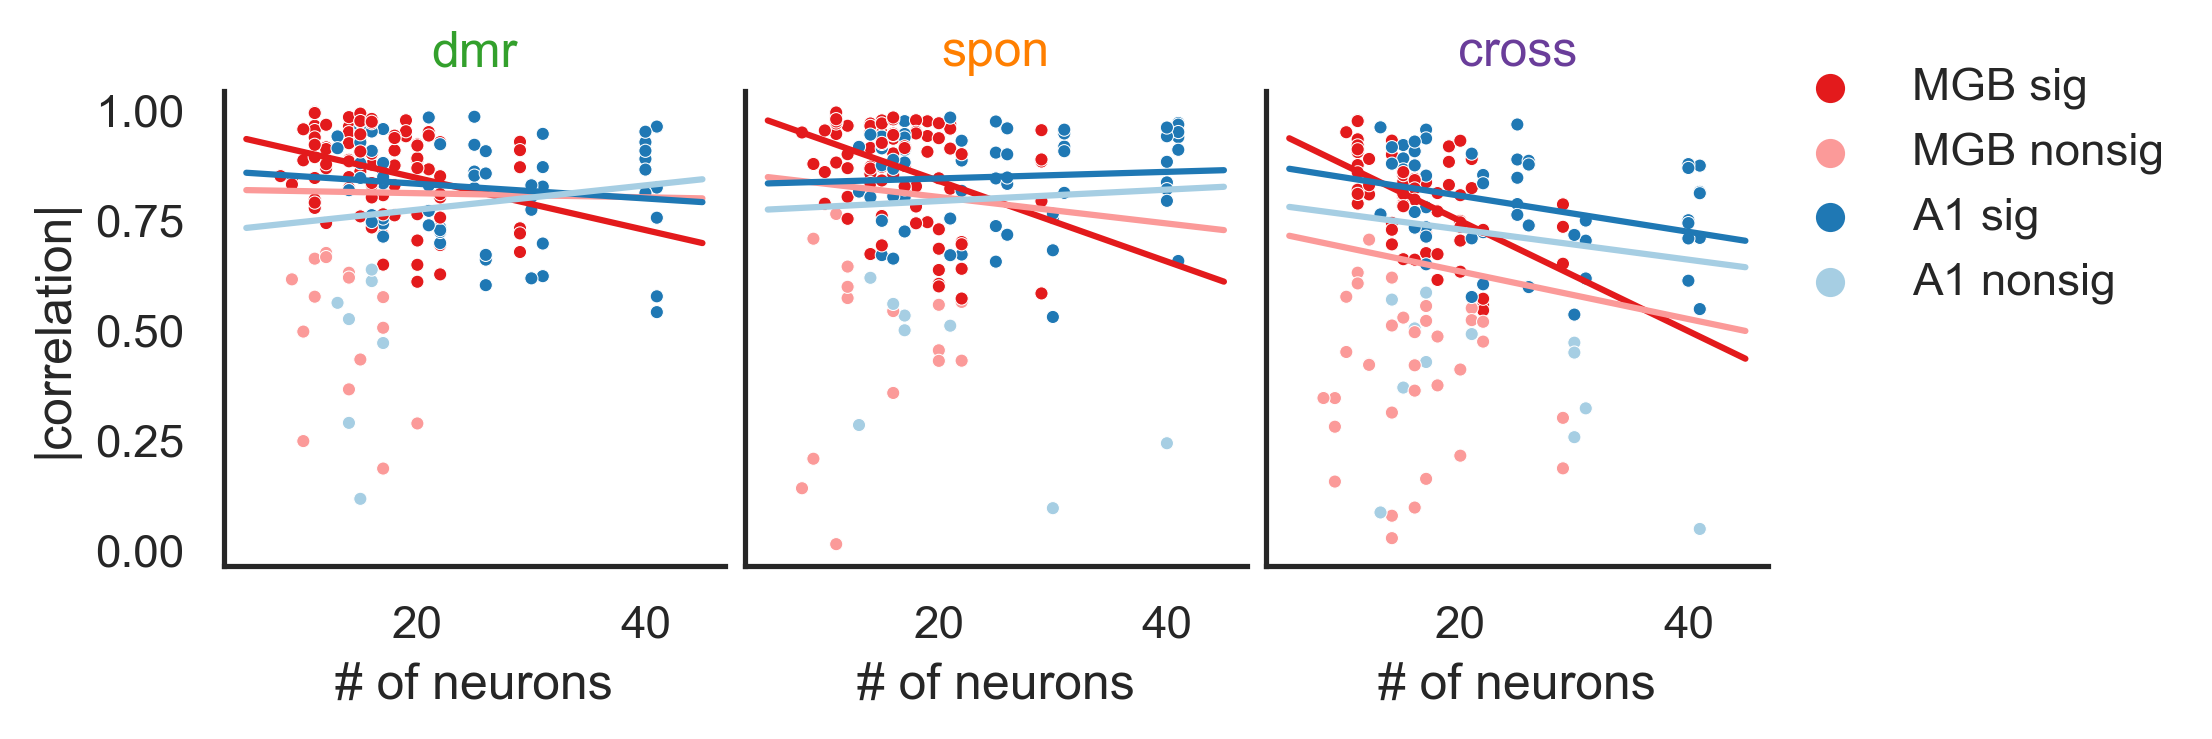

In [174]:
sns.set_style("white")
colors = MGB_color[:2] + A1_color[:2]
x = np.linspace(5, 45, 10)
g = sns.relplot(data=df, x='n_neuron', y='corr', col='stim', 
            hue='region_sig', hue_order=my_order, 
            palette=colors, s=10)
for j, ax in enumerate(g.axes[0]):
    stim = ax.get_title()[7:]
    for i, region in enumerate(['MGB', 'A1']):
        # significant values
        df_tmp = df[(df.stim == stim) & (df.region == region) & (df.corr_sig)]
        m, b = np.polyfit(df_tmp['n_neuron'], df_tmp['corr'], 1)
        ax.plot(x, m*x+b, color=colors[2*i])
        # all values
        df_tmp = df[(df.stim == stim) & (df.region == region)]
        m, b = np.polyfit(df_tmp['n_neuron'], df_tmp['corr'], 1)
        ax.plot(x, m*x+b, color=colors[2*i+1])
    ax.set_xlabel('# of neurons')
    ax.set_title(stim, color=colors_split[j*2])
g.axes[0][0].set_ylabel('|correlation|')
g.fig.set_size_inches(6,2)
for t, l in zip(g._legend.texts, ['MGB sig', 'MGB nonsig', 'A1 sig', 'A1 nonsig']):
    t.set_text(l)
sns.move_legend(g, "lower right", bbox_to_anchor=(1.15, 0.5), title=None)
plt.savefig('/Users/hucongcong/Documents/UCSF/data/figure/cNE-spon_dmr_stability/corr_vs_n_neuron.png', bbox_inches='tight')

While all correlation values are not strongly correlated with the total number of units in the recordings, significant correlation values are negatively correlated with the total number of neurons in the recording. This reflects higher significance threshold with lower number of units.

In [154]:
help(leg)

Help on Legend in module matplotlib.legend object:

class Legend(matplotlib.artist.Artist)
 |  Legend(parent, handles, labels, *, loc=None, numpoints=None, markerscale=None, markerfirst=True, scatterpoints=None, scatteryoffsets=None, prop=None, fontsize=None, labelcolor=None, borderpad=None, labelspacing=None, handlelength=None, handleheight=None, handletextpad=None, borderaxespad=None, columnspacing=None, ncols=1, mode=None, fancybox=None, shadow=None, title=None, title_fontsize=None, framealpha=None, edgecolor=None, facecolor=None, bbox_to_anchor=None, bbox_transform=None, frameon=None, handler_map=None, title_fontproperties=None, alignment='center', ncol=1)
 |  
 |  Place a legend on the axes at location loc.
 |  
 |  Method resolution order:
 |      Legend
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, parent, handles, labels, *, loc=None, numpoints=None, markerscale=None, markerfirst=True, scatterpoints=None, scatter